# YOLO V2 with TensorFlow 2.0

In [1]:
import os
import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import imgaug as ia
from imgaug import augmenters as iaa
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda

In [2]:
# 設定變數
LABELS           = ('sugarbeet', 'weed')
IMAGE_H, IMAGE_W = 512, 512
GRID_H,  GRID_W  = 16, 16 # GRID size = IMAGE size / 32
BOX              = 5
CLASS            = len(LABELS)
SCORE_THRESHOLD  = 0.5
IOU_THRESHOLD    = 0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
TRAIN_BATCH_SIZE = 10
VAL_BATCH_SIZE   = 10
EPOCHS           = 100
LAMBDA_NOOBJECT  = 1
LAMBDA_OBJECT    = 5
LAMBDA_CLASS     = 1
LAMBDA_COORD     = 1
max_annot        = 0

In [3]:
# 訓練和驗證文件路徑
train_image_folder = 'data/train/image/'
train_annot_folder = 'data/train/annotation/'
val_image_folder = 'data/val/image/'
val_annot_folder = 'data/val/annotation/'

In [4]:
# 客製化Keras層

class SpaceToDepth(keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)

In [5]:
# YOLO模型，https://github.com/experiencor/keras-yolo2

input_image = tf.keras.layers.Input((IMAGE_H, IMAGE_W, 3), dtype='float32')

# 第一層
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 第二層
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 第三層
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第四層
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第五層
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 第六層
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第七層
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第八層
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 第九層
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十層
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十一層
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十二層
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十三層
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# 第十四層
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十五層
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十六層
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十七層
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十八層
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第十九層
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第二十層
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# 第二十一層
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)

skip_connection = SpaceToDepth(block_size=2)(skip_connection)

x = concatenate([skip_connection, x])

# 第二十二層
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x) # add dropout

# 第二十三層
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_W, GRID_H, BOX, 4 + 1 + CLASS))(x)

model = keras.models.Model(input_image, output)

2022-03-01 19:41:08.070400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-01 19:41:08.070804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 512, 512, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 512, 512, 32  128         ['conv_1[0][0]']                 
                                )                                                             

In [7]:
# 載入預訓練的權重
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

In [8]:
weight_reader = WeightReader('weights/yolov2.weights')

In [9]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    conv_layer.trainable = True
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        norm_layer.trainable = True
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [10]:
layer   = model.layers[-2] # last convolutional layer
layer.trainable = True


weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

In [11]:
# 資料生成器（可以理解成給模型喂資料的程式）
def parse_annotation(ann_dir, img_dir, labels):
    
    max_annot = 0
    imgs_name = []
    annots = []
    
    # Parse file
    for ann in sorted(os.listdir(ann_dir)):
        annot_count = 0
        boxes = []
        tree = ET.parse(ann_dir + ann)
        for elem in tree.iter(): 
            if 'filename' in elem.tag:
                imgs_name.append(img_dir + elem.text)
            if 'width' in elem.tag:
                w = int(elem.text)
            if 'height' in elem.tag:
                h = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:                  
                box = np.zeros((5))
                for attr in list(elem):
                    if 'name' in attr.tag:
                        box[4] = labels.index(attr.text) + 1 # 0:label for no bounding box
                    if 'bndbox' in attr.tag:
                        annot_count += 1
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                box[0] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                box[1] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                box[2] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                box[3] = int(round(float(dim.text)))
                boxes.append(np.asarray(box))
        
        if w != IMAGE_W or h != IMAGE_H :
            print('Image size error')
            break
            
        annots.append(np.asarray(boxes))
        

        if annot_count > max_annot:
            max_annot = annot_count
           
    # Rectify annotations boxes : len -> max_annot
    imgs_name = np.array(imgs_name)  
    true_boxes = np.zeros((imgs_name.shape[0], max_annot, 5))
    for idx, boxes in enumerate(annots):
        true_boxes[idx, :boxes.shape[0], :5] = boxes
        
    return imgs_name, true_boxes

In [12]:
def parse_function(img_obj, true_boxes):
    x_img_string = tf.io.read_file(img_obj)
    x_img = tf.image.decode_png(x_img_string, channels=3)
    # RGB三通道，畫素灰階/255
    x_img = tf.image.convert_image_dtype(x_img, tf.float32)
    return x_img, true_boxes

def get_dataset(img_dir, ann_dir, labels, batch_size):
    imgs_name, bbox = parse_annotation(ann_dir, img_dir, LABELS)
    dataset = tf.data.Dataset.from_tensor_slices((imgs_name, bbox))    
    dataset = dataset.shuffle(len(imgs_name))
    dataset = dataset.repeat()
    dataset = dataset.map(parse_function, num_parallel_calls=6)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    print('-------------------')
    print('Dataset:')
    print('Images count: {}'.format(len(imgs_name)))
    print('Step per epoch: {}'.format(len(imgs_name) // batch_size))
    print('Images per epoch: {}'.format(batch_size * (len(imgs_name) // batch_size)))
    return dataset

In [13]:
train_dataset = None
train_dataset= get_dataset(train_image_folder, train_annot_folder, LABELS, TRAIN_BATCH_SIZE)

val_dataset = None
val_dataset= get_dataset(val_image_folder, val_annot_folder, LABELS, VAL_BATCH_SIZE)

-------------------
Dataset:
Images count: 100
Step per epoch: 10
Images per epoch: 100
-------------------
Dataset:
Images count: 20
Step per epoch: 2
Images per epoch: 20


In [14]:
def test_dataset(dataset):
    for batch in dataset:
        img = batch[0][0]
        label = batch[1][0]
        plt.figure(figsize=(2,2))
        f, (ax1) = plt.subplots(1,1, figsize=(10, 10))
        ax1.imshow(img)
        ax1.set_title('Input image. Shape : {}'.format(img.shape))
        for i in range(label.shape[0]):
            box = label[i,:]
            box = box.numpy()
            x = box[0]
            y = box[1]
            w = box[2] - box[0]
            h = box[3] - box[1]
            if box[4] == 1:
                color = (0, 1, 0)
            else:
                color = (1, 0, 0)
            rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor=color,facecolor='none')
            ax1.add_patch(rect)
        break

In [15]:
# 資料增強（基於有限圖像製作更多情形）
def augmentation_generator(yolo_dataset):
    for batch in yolo_dataset:
        # conversion tensor->numpy
        img = batch[0].numpy()
        boxes = batch[1]. numpy()
        # conversion bbox numpy->ia object
        ia_boxes = []
        for i in range(img.shape[0]):
            ia_bbs = [ia.BoundingBox(x1=bb[0],
                                       y1=bb[1],
                                       x2=bb[2],
                                       y2=bb[3]) for bb in boxes[i]
                      if (bb[0] + bb[1] +bb[2] + bb[3] > 0)]
            ia_boxes.append(ia.BoundingBoxesOnImage(ia_bbs, shape=(IMAGE_W, IMAGE_H)))
        # data augmentation
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Multiply((0.4, 1.6)), # change brightness
            #iaa.ContrastNormalization((0.5, 1.5)),
            #iaa.Affine(translate_px={"x": (-100,100), "y": (-100,100)}, scale=(0.7, 1.30))
            ])
        #seq = iaa.Sequential([])
        seq_det = seq.to_deterministic()
        img_aug = seq_det.augment_images(img)
        img_aug = np.clip(img_aug, 0, 1)
        boxes_aug = seq_det.augment_bounding_boxes(ia_boxes)
        # conversion ia object -> bbox numpy
        for i in range(img.shape[0]):
            boxes_aug[i] = boxes_aug[i].remove_out_of_image().clip_out_of_image()
            for j, bb in enumerate(boxes_aug[i].bounding_boxes):
                boxes[i,j,0] = bb.x1
                boxes[i,j,1] = bb.y1
                boxes[i,j,2] = bb.x2
                boxes[i,j,3] = bb.y2
        # conversion numpy->tensor
        batch = (tf.convert_to_tensor(img_aug), tf.convert_to_tensor(boxes))
        #batch = (img_aug, boxes)
        yield batch

In [16]:
aug_train_dataset = augmentation_generator(train_dataset)

In [17]:
def process_true_boxes(true_boxes, anchors, image_width, image_height):
    scale = IMAGE_W / GRID_W # scale = 32
    
    anchors_count = len(anchors) // 2
    anchors = np.array(anchors)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    detector_mask = np.zeros((GRID_W, GRID_H, anchors_count, 1))
    matching_true_boxes = np.zeros((GRID_W, GRID_H, anchors_count, 5))
    
    # convert true_boxes numpy array -> tensor
    true_boxes = true_boxes.numpy()
    
    true_boxes_grid = np.zeros(true_boxes.shape)
    
    # convert bounding box coords and localize bounding box
    for i, box in enumerate(true_boxes):
        # convert box coords to x, y, w, h and convert to grids coord
        w = (box[2] - box[0]) / scale
        h = (box[3] - box[1]) / scale    
        x = ((box[0] + box[2]) / 2) / scale
        y = ((box[1] + box[3]) / 2) / scale
        true_boxes_grid[i,...] = np.array([x, y, w, h, box[4]])
        if w * h > 0: # box exists
            # calculate iou between box and each anchors and find best anchors
            best_iou = 0
            best_anchor = 0
            for i in range(anchors_count): 
                # iou (anchor and box are shifted to 0,0)
                intersect = np.minimum(w, anchors[i,0]) * np.minimum(h, anchors[i,1])
                union = (anchors[i,0] * anchors[i,1]) + (w * h) - intersect
                iou = intersect / union
                if iou > best_iou:
                    best_iou = iou
                    best_anchor = i
            # localize box in detector_mask and matching true_boxes
            if best_iou > 0:
                x_coord = np.floor(x).astype('int')
                y_coord = np.floor(y).astype('int')
                detector_mask[y_coord, x_coord, best_anchor] = 1
                yolo_box = np.array([x, y, w, h, box[4]])
                matching_true_boxes[y_coord, x_coord, best_anchor] = yolo_box
    return matching_true_boxes, detector_mask, true_boxes_grid

In [18]:
def ground_truth_generator(dataset):
    for batch in dataset:
        # imgs
        imgs = batch[0]
        
        # true boxes
        true_boxes = batch[1]
        
        # matching_true_boxes and detector_mask
        batch_matching_true_boxes = []
        batch_detector_mask = []
        batch_true_boxes_grid = []
        
        for i in range(true_boxes.shape[0]):     
            one_matching_true_boxes, one_detector_mask, true_boxes_grid = process_true_boxes(true_boxes[i],
                                                                                           ANCHORS,
                                                                                           IMAGE_W,
                                                                                           IMAGE_H)
            batch_matching_true_boxes.append(one_matching_true_boxes)
            batch_detector_mask.append(one_detector_mask)
            batch_true_boxes_grid.append(true_boxes_grid)
                
        detector_mask = tf.convert_to_tensor(np.array(batch_detector_mask), dtype='float32')
        matching_true_boxes = tf.convert_to_tensor(np.array(batch_matching_true_boxes), dtype='float32')
        true_boxes_grid = tf.convert_to_tensor(np.array(batch_true_boxes_grid), dtype='float32')
        
        # class one_hot
        matching_classes = K.cast(matching_true_boxes[..., 4], 'int32') 
        class_one_hot = K.one_hot(matching_classes, CLASS + 1)[:,:,:,:,1:]
        class_one_hot = tf.cast(class_one_hot, dtype='float32')
        
        batch = (imgs, detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid)
        yield batch

In [19]:
# Ground true generator
train_gen = ground_truth_generator(aug_train_dataset)
val_gen = ground_truth_generator(val_dataset)

In [20]:
# 接下來有關訓練
def iou(x1, y1, w1, h1, x2, y2, w2, h2):
    xmin1 = x1 - 0.5*w1
    xmax1 = x1 + 0.5*w1
    ymin1 = y1 - 0.5*h1
    ymax1 = y1 + 0.5*h1
    xmin2 = x2 - 0.5*w2
    xmax2 = x2 + 0.5*w2
    ymin2 = y2 - 0.5*h2
    ymax2 = y2 + 0.5*h2
    interx = np.minimum(xmax1, xmax2) - np.maximum(xmin1, xmin2)
    intery = np.minimum(ymax1, ymax2) - np.maximum(ymin1, ymin2)
    inter = interx * intery
    union = w1*h1 + w2*h2 - inter
    iou = inter / (union + 1e-6)
    return iou

In [21]:
# Loss

def yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid, y_pred, info=False):
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])
    
    # coordinate loss
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2]) # adjust coords between 0 and 1
    pred_xy = (pred_xy + coords) # add cell coord for comparaison with ground truth. New coords in grid cell unit
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors # adjust width and height for comparaison with ground truth. New coords in grid cell unit
    #pred_wh = (pred_wh * anchors) # unit : grid cell
    nb_detector_mask = K.sum(tf.cast(detector_mask > 0.0, tf.float32))
    xy_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(matching_true_boxes[...,:2] - pred_xy)) / (nb_detector_mask + 1e-6) # Non /2
    wh_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(K.sqrt(matching_true_boxes[...,2:4]) - 
                                                            K.sqrt(pred_wh))) / (nb_detector_mask + 1e-6)
    coord_loss = xy_loss + wh_loss
    
    # class loss    
    pred_box_class = y_pred[..., 5:]
    true_box_class = tf.argmax(class_one_hot, -1)
    #class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    class_loss = K.sparse_categorical_crossentropy(target=true_box_class, output=pred_box_class, from_logits=True)
    class_loss = K.expand_dims(class_loss, -1) * detector_mask
    class_loss = LAMBDA_CLASS * K.sum(class_loss) / (nb_detector_mask + 1e-6)
    
    # confidence loss
    pred_conf = K.sigmoid(y_pred[...,4:5])
    # for each detector : iou between prediction and ground truth
    x1 = matching_true_boxes[...,0]
    y1 = matching_true_boxes[...,1]
    w1 = matching_true_boxes[...,2]
    h1 = matching_true_boxes[...,3]
    x2 = pred_xy[...,0]
    y2 = pred_xy[...,1]
    w2 = pred_wh[...,0]
    h2 = pred_wh[...,1]
    ious = iou(x1, y1, w1, h1, x2, y2, w2, h2)
    ious = K.expand_dims(ious, -1)
     
    # for each detector : best ious between prediction and true_boxes (every bounding box of image)
    pred_xy = K.expand_dims(pred_xy, 4) # shape : m, GRID_W, GRID_H, BOX, 1, 2 
    pred_wh = K.expand_dims(pred_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half
    true_boxe_shape = K.int_shape(true_boxes_grid)
    true_boxes_grid = K.reshape(true_boxes_grid, [true_boxe_shape[0], 1, 1, 1, true_boxe_shape[1], true_boxe_shape[2]])
    true_xy = true_boxes_grid[...,0:2]
    true_wh = true_boxes_grid[...,2:4]
    true_wh_half = true_wh * 0.5
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half
    intersect_mins = K.maximum(pred_mins, true_mins) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2 
    intersect_maxes = K.minimum(pred_maxes, true_maxes) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, 1, 1
    true_areas = true_wh[..., 0] * true_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious) # shape : m, GRID_W, GRID_H, BOX, 1
    
    # no object confidence loss
    no_object_detection = K.cast(best_ious < 0.6, K.dtype(best_ious)) 
    noobj_mask = no_object_detection * (1 - detector_mask)
    nb_noobj_mask  = K.sum(tf.cast(noobj_mask  > 0.0, tf.float32))
    
    noobject_loss =  LAMBDA_NOOBJECT * K.sum(noobj_mask * K.square(-pred_conf)) / (nb_noobj_mask + 1e-6)
    # object confidence loss
    object_loss = LAMBDA_OBJECT * K.sum(detector_mask * K.square(ious - pred_conf)) / (nb_detector_mask + 1e-6)
    # total confidence loss
    conf_loss = noobject_loss + object_loss
    
    # total loss
    loss = conf_loss + class_loss + coord_loss
    sub_loss = [conf_loss, class_loss, coord_loss]  

    if info:
        print('conf_loss   : {:.4f}'.format(conf_loss))
        print('class_loss  : {:.4f}'.format(class_loss))
        print('coord_loss  : {:.4f}'.format(coord_loss))
        print('    xy_loss : {:.4f}'.format(xy_loss))
        print('    wh_loss : {:.4f}'.format(wh_loss))
        print('--------------------')
        print('total loss  : {:.4f}'.format(loss))
        
        # display masks for each anchors
        for i in range(len(anchors)):
            f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
            f.tight_layout()
            f.suptitle('MASKS FOR ANCHOR {} :'.format(anchors[i,...]))
            
            ax1.matshow((K.sum(detector_mask[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax1.set_title('detector_mask, count : {}'.format(K.sum(tf.cast(detector_mask[0,:,:,i]  > 0., tf.int32))))
            ax1.xaxis.set_ticks_position('bottom')
            
            ax2.matshow((K.sum(no_object_detection[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax2.set_title('no_object_detection mask')
            ax2.xaxis.set_ticks_position('bottom')
            
            ax3.matshow((K.sum(noobj_mask[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax3.set_title('noobj_mask')
            ax3.xaxis.set_ticks_position('bottom')
              
    return loss, sub_loss

In [22]:
# gradients
def grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=True):
    with tf.GradientTape() as tape:
        y_pred = model(img, training)
        loss, sub_loss = yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes, y_pred)
    return loss, sub_loss, tape.gradient(loss, model.trainable_variables)

# save weights
def save_best_weights(model, name, val_loss_avg):
    # delete existing weights file
    files = glob.glob(os.path.join('weights/', name + '*'))
    for file in files:
        os.remove(file)
    # create new weights file
    name = name + '_' + str(val_loss_avg) + '.h5'
    path_name = os.path.join('weights/', name)
    model.save_weights(path_name)

# log (tensorboard)
def log_loss(loss, val_loss, step):
    tf.summary.scalar('loss', loss, step)
    tf.summary.scalar('val_loss', val_loss, step)

In [23]:
# training
def train(epochs, model, train_dataset, val_dataset, steps_per_epoch_train, steps_per_epoch_val, train_name = 'train'):
    num_epochs = epochs
    steps_per_epoch_train = steps_per_epoch_train
    steps_per_epoch_val = steps_per_epoch_val
    train_loss_history = []
    val_loss_history = []
    best_val_loss = 1e6
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer = tf.summary.create_file_writer(os.path.join('logs/', train_name), flush_millis=20000)
    summary_writer.set_as_default()
    
    # training
    for epoch in range(num_epochs):
        epoch_loss = []
        epoch_val_loss = []
        epoch_val_sub_loss = []
        print('Epoch {} :'.format(epoch))
        # train
        for batch_idx in range(steps_per_epoch_train): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(train_dataset)
            loss, _, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss.append(loss)
            print('-', end='')
        print(' | ', end='')
        # val
        for batch_idx in range(steps_per_epoch_val): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(val_dataset)
            loss, sub_loss, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=False)
            epoch_val_loss.append(loss)
            epoch_val_sub_loss.append(sub_loss)
            print('-', end='')

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = np.mean(np.array(epoch_val_loss))
        sub_loss_avg = np.mean(np.array(epoch_val_sub_loss), axis=0)
        train_loss_history.append(loss_avg)
        val_loss_history.append(val_loss_avg)
        
        # log
        log_loss(loss_avg, val_loss_avg, epoch)
        
        # save
        if val_loss_avg < best_val_loss:
            save_best_weights(model, train_name, val_loss_avg)
            best_val_loss = val_loss_avg
        
        print(' loss = {:.4f}, val_loss = {:.4f} (conf={:.4f}, class={:.4f}, coords={:.4f})'.format(
            loss_avg, val_loss_avg, sub_loss_avg[0], sub_loss_avg[1], sub_loss_avg[2]))
        
    return [train_loss_history, val_loss_history]

Epoch 0 :


2022-03-01 19:41:08.844404: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


---------- | -- loss = 1.4989, val_loss = 1.5168 (conf=0.5321, class=0.6675, coords=0.3171)
Epoch 1 :
---------- | -- loss = 1.4298, val_loss = 1.4128 (conf=0.4641, class=0.6282, coords=0.3204)
Epoch 2 :
---------- | -- loss = 1.3693, val_loss = 1.3637 (conf=0.4466, class=0.5811, coords=0.3360)
Epoch 3 :
---------- | -- loss = 1.3026, val_loss = 1.2935 (conf=0.4326, class=0.5337, coords=0.3272)
Epoch 4 :
---------- | -- loss = 1.2346, val_loss = 1.2163 (conf=0.4276, class=0.4793, coords=0.3093)
Epoch 5 :
---------- | -- loss = 1.1644, val_loss = 1.1117 (conf=0.3873, class=0.4233, coords=0.3011)
Epoch 6 :
---------- | -- loss = 1.1205, val_loss = 1.0308 (conf=0.3582, class=0.3705, coords=0.3021)
Epoch 7 :
---------- | -- loss = 1.0536, val_loss = 0.9953 (conf=0.3686, class=0.3320, coords=0.2947)
Epoch 8 :
---------- | -- loss = 1.0114, val_loss = 0.9387 (conf=0.3558, class=0.2948, coords=0.2881)
Epoch 9 :
---------- | -- loss = 0.9774, val_loss = 0.9094 (conf=0.3637, class=0.2655, coord

---------- | -- loss = 0.3489, val_loss = 0.3601 (conf=0.1471, class=0.0323, coords=0.1808)
Epoch 81 :
---------- | -- loss = 0.3426, val_loss = 0.3980 (conf=0.1547, class=0.0344, coords=0.2089)
Epoch 82 :
---------- | -- loss = 0.3341, val_loss = 0.3761 (conf=0.1513, class=0.0339, coords=0.1908)
Epoch 83 :
---------- | -- loss = 0.3470, val_loss = 0.3900 (conf=0.1534, class=0.0326, coords=0.2040)
Epoch 84 :
---------- | -- loss = 0.3381, val_loss = 0.3709 (conf=0.1482, class=0.0320, coords=0.1908)
Epoch 85 :
---------- | -- loss = 0.3302, val_loss = 0.3862 (conf=0.1504, class=0.0323, coords=0.2035)
Epoch 86 :
---------- | -- loss = 0.3334, val_loss = 0.3764 (conf=0.1486, class=0.0324, coords=0.1954)
Epoch 87 :
---------- | -- loss = 0.3195, val_loss = 0.3548 (conf=0.1395, class=0.0304, coords=0.1849)
Epoch 88 :
---------- | -- loss = 0.3347, val_loss = 0.3581 (conf=0.1450, class=0.0304, coords=0.1826)
Epoch 89 :
---------- | -- loss = 0.3178, val_loss = 0.3698 (conf=0.1494, class=0.03

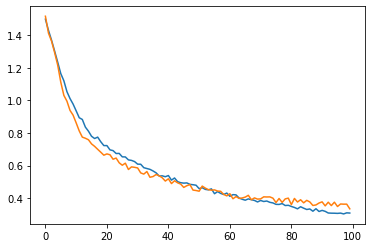

In [24]:
results = train(EPOCHS, model, train_gen, val_gen, 10, 2, 'training_1')

plt.plot(results[0])
plt.plot(results[1])

In [25]:
def display_yolo(file, model, score_threshold, iou_threshold):
    # load image
    image = cv2.imread(file)

    input_image = image[:,:,::-1]
    input_image = image / 255.
    input_image = np.expand_dims(input_image, 0)

    # prediction
    y_pred = model.predict_on_batch(input_image)

    # post prediction process
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [TRAIN_BATCH_SIZE, 1, 1, 5, 1])
    dims = K.cast_to_floatx(K.int_shape(y_pred)[1:3])
    dims = K.reshape(dims,(1,1,1,1,2))
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    # pred_xy and pred_wh shape (m, GRID_W, GRID_H, Anchors, 2)
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xy = (pred_xy + coords)
    pred_xy = pred_xy / dims
    pred_wh = K.exp(y_pred[:,:,:,:,2:4])
    pred_wh = (pred_wh * anchors)
    pred_wh = pred_wh / dims
    # pred_confidence
    box_conf = K.sigmoid(y_pred[:,:,:,:,4:5])  
    # pred_class
    box_class_prob = K.softmax(y_pred[:,:,:,:,5:])

    # Reshape
    pred_xy = pred_xy[0,...]
    pred_wh = pred_wh[0,...]
    box_conf = box_conf[0,...]
    box_class_prob = box_class_prob[0,...]

    # Convert box coords from x,y,w,h to x1,y1,x2,y2
    box_xy1 = pred_xy - 0.5 * pred_wh
    box_xy2 = pred_xy + 0.5 * pred_wh
    boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

    # Filter boxes
    box_scores = box_conf * box_class_prob
    box_classes = K.argmax(box_scores, axis=-1) # best score index
    box_class_scores = K.max(box_scores, axis=-1) # best score
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)

    # Scale box to image shape
    boxes = boxes * IMAGE_H

    # Non Max Supression
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)
    scores = K.gather(scores, selected_idx)
    classes = K.gather(classes, selected_idx)
    
    # Draw image
    plt.figure(figsize=(2,2))
    f, (ax1) = plt.subplots(1,1, figsize=(10, 10))
    ax1.imshow(image[:,:,::-1])
    count_detected = boxes.shape[0]
    ax1.set_title('Detected objects count : {}'.format(count_detected))
    for i in range(count_detected):
        box = boxes[i,...]
        x = box[0]
        y = box[1]
        w = box[2] - box[0]
        h = box[3] - box[1]
        classe = classes[i].numpy()
        if classe == 0:
            color = (0, 1, 0)
        else:
            color = (1, 0, 0)
        rect = patches.Rectangle((x.numpy(), y.numpy()), w.numpy(), h.numpy(), linewidth = 3, edgecolor=color,facecolor='none')
        ax1.add_patch(rect)

2022-03-01 19:49:20.543805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


<Figure size 144x144 with 0 Axes>

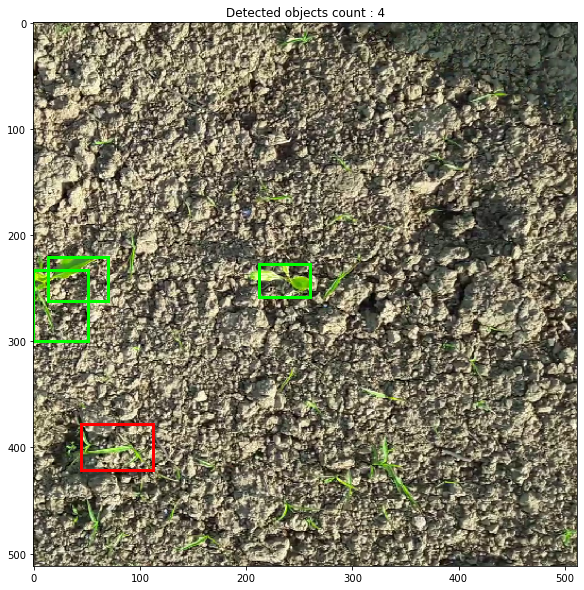

<Figure size 144x144 with 0 Axes>

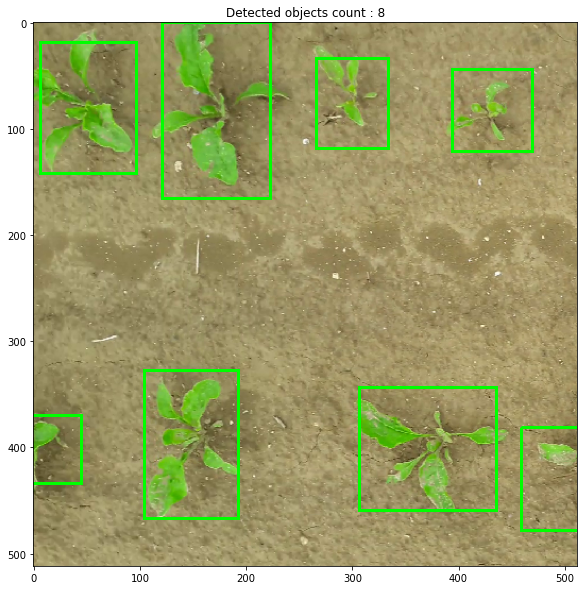

<Figure size 144x144 with 0 Axes>

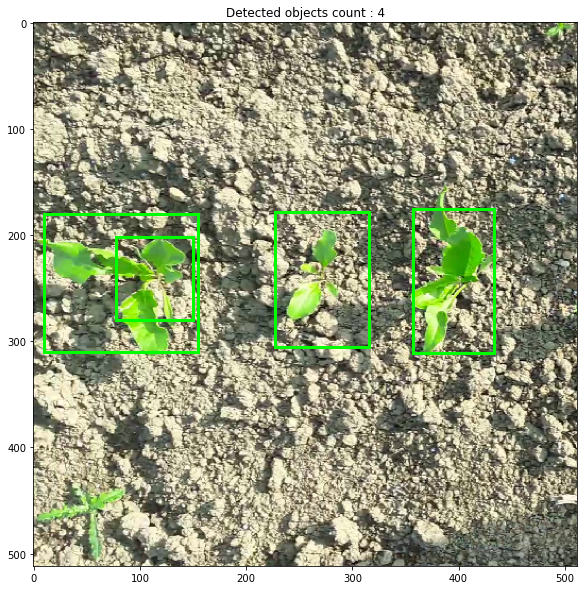

<Figure size 144x144 with 0 Axes>

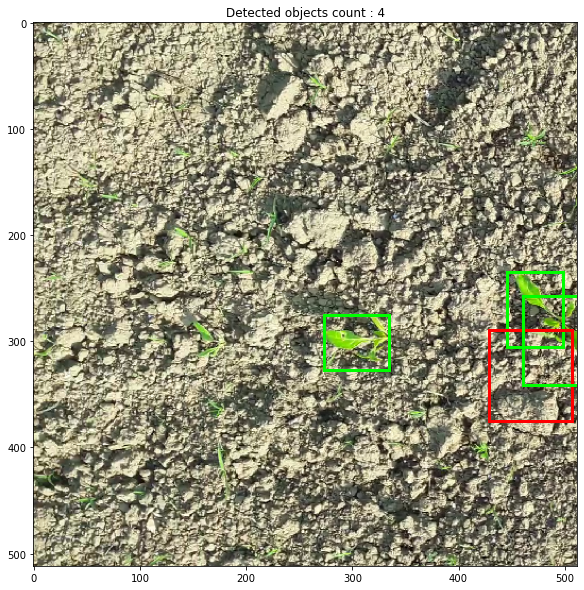

<Figure size 144x144 with 0 Axes>

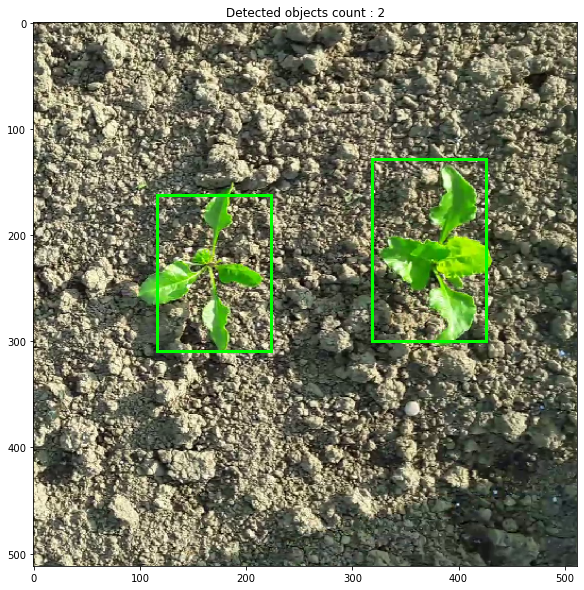

<Figure size 144x144 with 0 Axes>

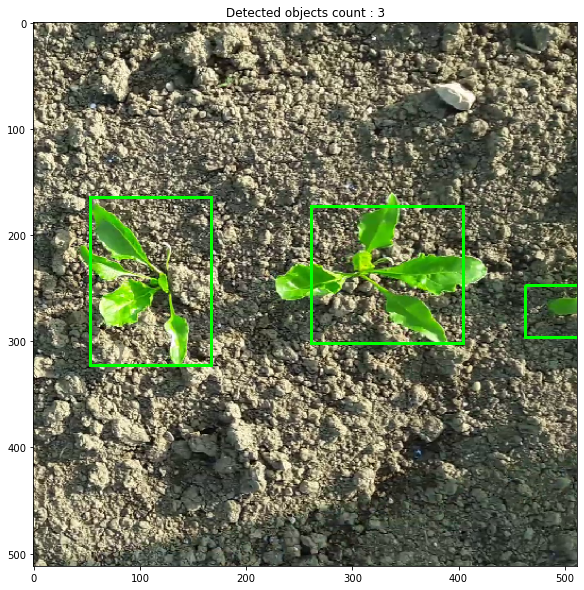

<Figure size 144x144 with 0 Axes>

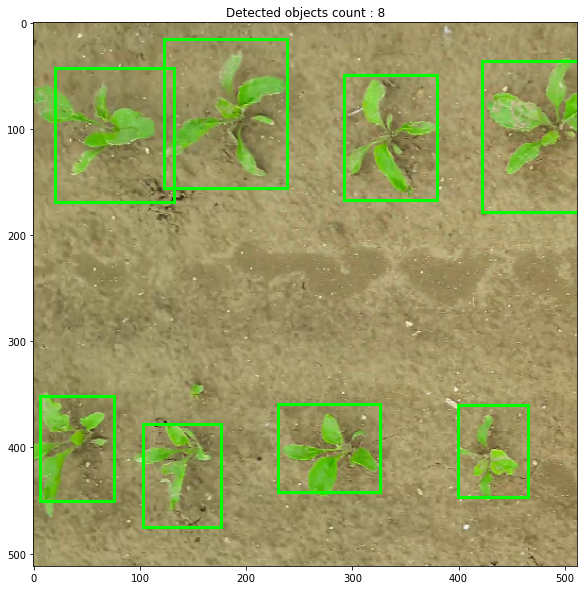

In [26]:
x_files =  glob.glob('data/val/image/*.png')

score = SCORE_THRESHOLD
iou_threshold = IOU_THRESHOLD

score = 0.45
iou_threshold = 0.3

for file in x_files[::3]:
    display_yolo(file, model, score, iou_threshold)